In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[2] += v[2]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b and x[2]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b and x[2]<b:
            ch = 1.0
            stop = True
        elif x[2]>= b and x[0]<b and x[1]<b:
            ch = 2.0
            stop = True
        elif (x[0]>= b and x[1]>=b) or (x[1]>= b and x[2]>=b) or (x[0]>= b and x[2]>=b):
            rt = 0
            x = np.array([0.0, 0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Kr2011_prep.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(tr_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'item_value_2', 
                            'gaze_0', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'item_value_2', 
                           'gaze_0', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2922, 6) (2922, 6)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)


def G2(data, pred):
    
    sbj_indices = tf.cast(data[:, 4], tf.int32)
    
    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))
    
    ll1 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll2 = (obs_train[:, 2]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll3 = (obs_train[:, 3]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    
    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2 + ll3, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=3, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 10]
input_shape = 6
output_shape = 3
activation = 'sigmoid'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 out_layer (Out_layer)       (None, 3)                 123       
                                                                 
Total params: 523 (2.04 KB)
Trainable params: 523 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 4], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 1s 1s/step - loss: 28503.1367
Epoch 2/5000
1/1 [==============================] - 0s 5ms/step - loss: 28289.1523
Epoch 3/5000
1/1 [==============================] - 0s 5ms/step - loss: 28137.4043
Epoch 4/5000
1/1 [==============================] - 0s 5ms/step - loss: 28012.3047
Epoch 5/5000
1/1 [==============================] - 0s 6ms/step - loss: 27902.6484
Epoch 6/5000
1/1 [==============================] - 0s 6ms/step - loss: 27803.2578
Epoch 7/5000
1/1 [==============================] - 0s 8ms/step - loss: 27711.2520
Epoch 8/5000
1/1 [==============================] - 0s 6ms/step - loss: 27624.8301
Epoch 9/5000
1/1 [==============================] - 0s 7ms/step - loss: 27542.7949
Epoch 10/5000
1/1 [==============================] - 0s 6ms/step - loss: 27464.2988
Epoch 11/5000
1/1 [==============================] - 0s 8ms/step - loss: 27388.7090
Epoch 12/5000
1/1 [==============================] - 0s 6ms/step - loss: 27315.5645
Ep

1/1 [==============================] - 0s 11ms/step - loss: 23083.3164
Epoch 99/5000
1/1 [==============================] - 0s 8ms/step - loss: 23046.6777
Epoch 100/5000
1/1 [==============================] - 0s 6ms/step - loss: 23010.2910
Epoch 101/5000
1/1 [==============================] - 0s 7ms/step - loss: 22974.1523
Epoch 102/5000
1/1 [==============================] - 0s 8ms/step - loss: 22938.2656
Epoch 103/5000
1/1 [==============================] - 0s 10ms/step - loss: 22902.6211
Epoch 104/5000
1/1 [==============================] - 0s 7ms/step - loss: 22867.2266
Epoch 105/5000
1/1 [==============================] - 0s 6ms/step - loss: 22832.0762
Epoch 106/5000
1/1 [==============================] - 0s 8ms/step - loss: 22797.1719
Epoch 107/5000
1/1 [==============================] - 0s 11ms/step - loss: 22762.5098
Epoch 108/5000
1/1 [==============================] - 0s 9ms/step - loss: 22728.0879
Epoch 109/5000
1/1 [==============================] - 0s 8ms/step - loss: 2269

1/1 [==============================] - 0s 4ms/step - loss: 20519.6602
Epoch 195/5000
1/1 [==============================] - 0s 4ms/step - loss: 20500.8398
Epoch 196/5000
1/1 [==============================] - 0s 5ms/step - loss: 20482.1348
Epoch 197/5000
1/1 [==============================] - 0s 4ms/step - loss: 20463.5488
Epoch 198/5000
1/1 [==============================] - 0s 4ms/step - loss: 20445.0742
Epoch 199/5000
1/1 [==============================] - 0s 4ms/step - loss: 20426.7129
Epoch 200/5000
1/1 [==============================] - 0s 4ms/step - loss: 20408.4629
Epoch 201/5000
1/1 [==============================] - 0s 4ms/step - loss: 20390.3242
Epoch 202/5000
1/1 [==============================] - 0s 4ms/step - loss: 20372.2949
Epoch 203/5000
1/1 [==============================] - 0s 4ms/step - loss: 20354.3730
Epoch 204/5000
1/1 [==============================] - 0s 4ms/step - loss: 20336.5566
Epoch 205/5000
1/1 [==============================] - 0s 4ms/step - loss: 20318.

1/1 [==============================] - 0s 4ms/step - loss: 19099.5742
Epoch 291/5000
1/1 [==============================] - 0s 4ms/step - loss: 19087.6680
Epoch 292/5000
1/1 [==============================] - 0s 4ms/step - loss: 19075.8047
Epoch 293/5000
1/1 [==============================] - 0s 5ms/step - loss: 19063.9746
Epoch 294/5000
1/1 [==============================] - 0s 4ms/step - loss: 19052.1914
Epoch 295/5000
1/1 [==============================] - 0s 4ms/step - loss: 19040.4473
Epoch 296/5000
1/1 [==============================] - 0s 4ms/step - loss: 19028.7344
Epoch 297/5000
1/1 [==============================] - 0s 4ms/step - loss: 19017.0684
Epoch 298/5000
1/1 [==============================] - 0s 4ms/step - loss: 19005.4375
Epoch 299/5000
1/1 [==============================] - 0s 4ms/step - loss: 18993.8418
Epoch 300/5000
1/1 [==============================] - 0s 4ms/step - loss: 18982.2832
Epoch 301/5000
1/1 [==============================] - 0s 4ms/step - loss: 18970.

1/1 [==============================] - 0s 4ms/step - loss: 18096.2422
Epoch 387/5000
1/1 [==============================] - 0s 4ms/step - loss: 18086.9258
Epoch 388/5000
1/1 [==============================] - 0s 3ms/step - loss: 18077.6250
Epoch 389/5000
1/1 [==============================] - 0s 4ms/step - loss: 18068.3457
Epoch 390/5000
1/1 [==============================] - 0s 3ms/step - loss: 18059.0820
Epoch 391/5000
1/1 [==============================] - 0s 4ms/step - loss: 18049.8359
Epoch 392/5000
1/1 [==============================] - 0s 4ms/step - loss: 18040.6094
Epoch 393/5000
1/1 [==============================] - 0s 4ms/step - loss: 18031.4004
Epoch 394/5000
1/1 [==============================] - 0s 4ms/step - loss: 18022.2070
Epoch 395/5000
1/1 [==============================] - 0s 4ms/step - loss: 18013.0332
Epoch 396/5000
1/1 [==============================] - 0s 4ms/step - loss: 18003.8770
Epoch 397/5000
1/1 [==============================] - 0s 4ms/step - loss: 17994.

1/1 [==============================] - 0s 3ms/step - loss: 17273.7676
Epoch 483/5000
1/1 [==============================] - 0s 3ms/step - loss: 17265.8770
Epoch 484/5000
1/1 [==============================] - 0s 3ms/step - loss: 17258.0039
Epoch 485/5000
1/1 [==============================] - 0s 3ms/step - loss: 17250.1426
Epoch 486/5000
1/1 [==============================] - 0s 3ms/step - loss: 17242.2930
Epoch 487/5000
1/1 [==============================] - 0s 4ms/step - loss: 17234.4570
Epoch 488/5000
1/1 [==============================] - 0s 4ms/step - loss: 17226.6328
Epoch 489/5000
1/1 [==============================] - 0s 4ms/step - loss: 17218.8223
Epoch 490/5000
1/1 [==============================] - 0s 4ms/step - loss: 17211.0254
Epoch 491/5000
1/1 [==============================] - 0s 4ms/step - loss: 17203.2363
Epoch 492/5000
1/1 [==============================] - 0s 4ms/step - loss: 17195.4648
Epoch 493/5000
1/1 [==============================] - 0s 4ms/step - loss: 17187.

1/1 [==============================] - 0s 4ms/step - loss: 16572.4707
Epoch 579/5000
1/1 [==============================] - 0s 4ms/step - loss: 16565.7383
Epoch 580/5000
1/1 [==============================] - 0s 5ms/step - loss: 16559.0234
Epoch 581/5000
1/1 [==============================] - 0s 4ms/step - loss: 16552.3164
Epoch 582/5000
1/1 [==============================] - 0s 4ms/step - loss: 16545.6211
Epoch 583/5000
1/1 [==============================] - 0s 4ms/step - loss: 16538.9395
Epoch 584/5000
1/1 [==============================] - 0s 4ms/step - loss: 16532.2695
Epoch 585/5000
1/1 [==============================] - 0s 4ms/step - loss: 16525.6094
Epoch 586/5000
1/1 [==============================] - 0s 4ms/step - loss: 16518.9609
Epoch 587/5000
1/1 [==============================] - 0s 4ms/step - loss: 16512.3242
Epoch 588/5000
1/1 [==============================] - 0s 4ms/step - loss: 16505.7031
Epoch 589/5000
1/1 [==============================] - 0s 4ms/step - loss: 16499.

1/1 [==============================] - 0s 4ms/step - loss: 15977.9932
Epoch 675/5000
1/1 [==============================] - 0s 4ms/step - loss: 15972.3398
Epoch 676/5000
1/1 [==============================] - 0s 4ms/step - loss: 15966.6982
Epoch 677/5000
1/1 [==============================] - 0s 5ms/step - loss: 15961.0664
Epoch 678/5000
1/1 [==============================] - 0s 5ms/step - loss: 15955.4482
Epoch 679/5000
1/1 [==============================] - 0s 5ms/step - loss: 15949.8398
Epoch 680/5000
1/1 [==============================] - 0s 4ms/step - loss: 15944.2441
Epoch 681/5000
1/1 [==============================] - 0s 5ms/step - loss: 15938.6553
Epoch 682/5000
1/1 [==============================] - 0s 5ms/step - loss: 15933.0811
Epoch 683/5000
1/1 [==============================] - 0s 5ms/step - loss: 15927.5137
Epoch 684/5000
1/1 [==============================] - 0s 4ms/step - loss: 15921.9648
Epoch 685/5000
1/1 [==============================] - 0s 4ms/step - loss: 15916.

1/1 [==============================] - 0s 4ms/step - loss: 15485.3516
Epoch 771/5000
1/1 [==============================] - 0s 4ms/step - loss: 15480.7324
Epoch 772/5000
1/1 [==============================] - 0s 4ms/step - loss: 15476.1191
Epoch 773/5000
1/1 [==============================] - 0s 4ms/step - loss: 15471.5205
Epoch 774/5000
1/1 [==============================] - 0s 4ms/step - loss: 15466.9307
Epoch 775/5000
1/1 [==============================] - 0s 4ms/step - loss: 15462.3467
Epoch 776/5000
1/1 [==============================] - 0s 4ms/step - loss: 15457.7754
Epoch 777/5000
1/1 [==============================] - 0s 3ms/step - loss: 15453.2139
Epoch 778/5000
1/1 [==============================] - 0s 4ms/step - loss: 15448.6621
Epoch 779/5000
1/1 [==============================] - 0s 4ms/step - loss: 15444.1221
Epoch 780/5000
1/1 [==============================] - 0s 4ms/step - loss: 15439.5869
Epoch 781/5000
1/1 [==============================] - 0s 3ms/step - loss: 15435.

1/1 [==============================] - 0s 5ms/step - loss: 15084.3809
Epoch 867/5000
1/1 [==============================] - 0s 4ms/step - loss: 15080.6328
Epoch 868/5000
1/1 [==============================] - 0s 4ms/step - loss: 15076.8936
Epoch 869/5000
1/1 [==============================] - 0s 5ms/step - loss: 15073.1641
Epoch 870/5000
1/1 [==============================] - 0s 6ms/step - loss: 15069.4414
Epoch 871/5000
1/1 [==============================] - 0s 5ms/step - loss: 15065.7285
Epoch 872/5000
1/1 [==============================] - 0s 5ms/step - loss: 15062.0244
Epoch 873/5000
1/1 [==============================] - 0s 4ms/step - loss: 15058.3281
Epoch 874/5000
1/1 [==============================] - 0s 4ms/step - loss: 15054.6377
Epoch 875/5000
1/1 [==============================] - 0s 4ms/step - loss: 15050.9600
Epoch 876/5000
1/1 [==============================] - 0s 5ms/step - loss: 15047.2871
Epoch 877/5000
1/1 [==============================] - 0s 5ms/step - loss: 15043.

1/1 [==============================] - 0s 4ms/step - loss: 14760.7188
Epoch 963/5000
1/1 [==============================] - 0s 5ms/step - loss: 14757.6895
Epoch 964/5000
1/1 [==============================] - 0s 4ms/step - loss: 14754.6670
Epoch 965/5000
1/1 [==============================] - 0s 5ms/step - loss: 14751.6523
Epoch 966/5000
1/1 [==============================] - 0s 4ms/step - loss: 14748.6416
Epoch 967/5000
1/1 [==============================] - 0s 4ms/step - loss: 14745.6377
Epoch 968/5000
1/1 [==============================] - 0s 5ms/step - loss: 14742.6396
Epoch 969/5000
1/1 [==============================] - 0s 4ms/step - loss: 14739.6465
Epoch 970/5000
1/1 [==============================] - 0s 4ms/step - loss: 14736.6611
Epoch 971/5000
1/1 [==============================] - 0s 4ms/step - loss: 14733.6826
Epoch 972/5000
1/1 [==============================] - 0s 5ms/step - loss: 14730.7061
Epoch 973/5000
1/1 [==============================] - 0s 4ms/step - loss: 14727.

1/1 [==============================] - 0s 4ms/step - loss: 14493.9648
Epoch 1058/5000
1/1 [==============================] - 0s 4ms/step - loss: 14491.2803
Epoch 1059/5000
1/1 [==============================] - 0s 4ms/step - loss: 14488.5986
Epoch 1060/5000
1/1 [==============================] - 0s 4ms/step - loss: 14485.9141
Epoch 1061/5000
1/1 [==============================] - 0s 6ms/step - loss: 14483.2324
Epoch 1062/5000
1/1 [==============================] - 0s 5ms/step - loss: 14480.5459
Epoch 1063/5000
1/1 [==============================] - 0s 6ms/step - loss: 14477.8633
Epoch 1064/5000
1/1 [==============================] - 0s 4ms/step - loss: 14475.1758
Epoch 1065/5000
1/1 [==============================] - 0s 4ms/step - loss: 14472.4883
Epoch 1066/5000
1/1 [==============================] - 0s 5ms/step - loss: 14469.7998
Epoch 1067/5000
1/1 [==============================] - 0s 5ms/step - loss: 14467.1113
Epoch 1068/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 14224.0518
Epoch 1153/5000
1/1 [==============================] - 0s 4ms/step - loss: 14220.9531
Epoch 1154/5000
1/1 [==============================] - 0s 5ms/step - loss: 14217.8496
Epoch 1155/5000
1/1 [==============================] - 0s 5ms/step - loss: 14214.7402
Epoch 1156/5000
1/1 [==============================] - 0s 4ms/step - loss: 14211.6260
Epoch 1157/5000
1/1 [==============================] - 0s 4ms/step - loss: 14208.5078
Epoch 1158/5000
1/1 [==============================] - 0s 4ms/step - loss: 14205.3838
Epoch 1159/5000
1/1 [==============================] - 0s 4ms/step - loss: 14202.2549
Epoch 1160/5000
1/1 [==============================] - 0s 4ms/step - loss: 14199.1221
Epoch 1161/5000
1/1 [==============================] - 0s 4ms/step - loss: 14195.9854
Epoch 1162/5000
1/1 [==============================] - 0s 4ms/step - loss: 14192.8428
Epoch 1163/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 13924.4766
Epoch 1248/5000
1/1 [==============================] - 0s 3ms/step - loss: 13921.4473
Epoch 1249/5000
1/1 [==============================] - 0s 4ms/step - loss: 13918.4229
Epoch 1250/5000
1/1 [==============================] - 0s 3ms/step - loss: 13915.4062
Epoch 1251/5000
1/1 [==============================] - 0s 3ms/step - loss: 13912.3906
Epoch 1252/5000
1/1 [==============================] - 0s 4ms/step - loss: 13909.3799
Epoch 1253/5000
1/1 [==============================] - 0s 3ms/step - loss: 13906.3721
Epoch 1254/5000
1/1 [==============================] - 0s 3ms/step - loss: 13903.3721
Epoch 1255/5000
1/1 [==============================] - 0s 4ms/step - loss: 13900.3740
Epoch 1256/5000
1/1 [==============================] - 0s 3ms/step - loss: 13897.3799
Epoch 1257/5000
1/1 [==============================] - 0s 3ms/step - loss: 13894.3887
Epoch 1258/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 13660.9307
Epoch 1343/5000
1/1 [==============================] - 0s 3ms/step - loss: 13658.4912
Epoch 1344/5000
1/1 [==============================] - 0s 4ms/step - loss: 13656.0586
Epoch 1345/5000
1/1 [==============================] - 0s 4ms/step - loss: 13653.6328
Epoch 1346/5000
1/1 [==============================] - 0s 4ms/step - loss: 13651.2119
Epoch 1347/5000
1/1 [==============================] - 0s 3ms/step - loss: 13648.7949
Epoch 1348/5000
1/1 [==============================] - 0s 4ms/step - loss: 13646.3857
Epoch 1349/5000
1/1 [==============================] - 0s 4ms/step - loss: 13643.9824
Epoch 1350/5000
1/1 [==============================] - 0s 4ms/step - loss: 13641.5820
Epoch 1351/5000
1/1 [==============================] - 0s 4ms/step - loss: 13639.1885
Epoch 1352/5000
1/1 [==============================] - 0s 4ms/step - loss: 13636.8008
Epoch 1353/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 13439.3174
Epoch 1438/5000
1/1 [==============================] - 0s 4ms/step - loss: 13436.8340
Epoch 1439/5000
1/1 [==============================] - 0s 4ms/step - loss: 13434.3350
Epoch 1440/5000
1/1 [==============================] - 0s 4ms/step - loss: 13431.8262
Epoch 1441/5000
1/1 [==============================] - 0s 5ms/step - loss: 13429.3018
Epoch 1442/5000
1/1 [==============================] - 0s 4ms/step - loss: 13426.7676
Epoch 1443/5000
1/1 [==============================] - 0s 4ms/step - loss: 13424.2158
Epoch 1444/5000
1/1 [==============================] - 0s 3ms/step - loss: 13421.6553
Epoch 1445/5000
1/1 [==============================] - 0s 4ms/step - loss: 13419.0762
Epoch 1446/5000
1/1 [==============================] - 0s 5ms/step - loss: 13416.4844
Epoch 1447/5000
1/1 [==============================] - 0s 4ms/step - loss: 13413.8750
Epoch 1448/5000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 13098.1631
Epoch 1533/5000
1/1 [==============================] - 0s 5ms/step - loss: 13093.0176
Epoch 1534/5000
1/1 [==============================] - 0s 3ms/step - loss: 13087.8320
Epoch 1535/5000
1/1 [==============================] - 0s 4ms/step - loss: 13082.6123
Epoch 1536/5000
1/1 [==============================] - 0s 5ms/step - loss: 13077.3525
Epoch 1537/5000
1/1 [==============================] - 0s 6ms/step - loss: 13072.0576
Epoch 1538/5000
1/1 [==============================] - 0s 6ms/step - loss: 13066.7256
Epoch 1539/5000
1/1 [==============================] - 0s 9ms/step - loss: 13061.3584
Epoch 1540/5000
1/1 [==============================] - 0s 5ms/step - loss: 13055.9521
Epoch 1541/5000
1/1 [==============================] - 0s 8ms/step - loss: 13050.5117
Epoch 1542/5000
1/1 [==============================] - 0s 5ms/step - loss: 13045.0332
Epoch 1543/5000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 12490.2021
Epoch 1628/5000
1/1 [==============================] - 0s 4ms/step - loss: 12483.4111
Epoch 1629/5000
1/1 [==============================] - 0s 5ms/step - loss: 12476.6396
Epoch 1630/5000
1/1 [==============================] - 0s 4ms/step - loss: 12469.8818
Epoch 1631/5000
1/1 [==============================] - 0s 5ms/step - loss: 12463.1426
Epoch 1632/5000
1/1 [==============================] - 0s 5ms/step - loss: 12456.4258
Epoch 1633/5000
1/1 [==============================] - 0s 5ms/step - loss: 12449.7275
Epoch 1634/5000
1/1 [==============================] - 0s 4ms/step - loss: 12443.0469
Epoch 1635/5000
1/1 [==============================] - 0s 4ms/step - loss: 12436.3916
Epoch 1636/5000
1/1 [==============================] - 0s 4ms/step - loss: 12429.7578
Epoch 1637/5000
1/1 [==============================] - 0s 3ms/step - loss: 12423.1484
Epoch 1638/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 11996.3438
Epoch 1723/5000
1/1 [==============================] - 0s 7ms/step - loss: 11992.9121
Epoch 1724/5000
1/1 [==============================] - 0s 5ms/step - loss: 11989.5020
Epoch 1725/5000
1/1 [==============================] - 0s 6ms/step - loss: 11986.1221
Epoch 1726/5000
1/1 [==============================] - 0s 6ms/step - loss: 11982.7656
Epoch 1727/5000
1/1 [==============================] - 0s 7ms/step - loss: 11979.4355
Epoch 1728/5000
1/1 [==============================] - 0s 5ms/step - loss: 11976.1318
Epoch 1729/5000
1/1 [==============================] - 0s 6ms/step - loss: 11972.8506
Epoch 1730/5000
1/1 [==============================] - 0s 5ms/step - loss: 11969.5957
Epoch 1731/5000
1/1 [==============================] - 0s 5ms/step - loss: 11966.3672
Epoch 1732/5000
1/1 [==============================] - 0s 6ms/step - loss: 11963.1592
Epoch 1733/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 11748.6504
Epoch 1818/5000
1/1 [==============================] - 0s 6ms/step - loss: 11746.5205
Epoch 1819/5000
1/1 [==============================] - 0s 5ms/step - loss: 11744.3887
Epoch 1820/5000
1/1 [==============================] - 0s 4ms/step - loss: 11742.2695
Epoch 1821/5000
1/1 [==============================] - 0s 6ms/step - loss: 11740.1367
Epoch 1822/5000
1/1 [==============================] - 0s 4ms/step - loss: 11738.0215
Epoch 1823/5000
1/1 [==============================] - 0s 4ms/step - loss: 11735.9023
Epoch 1824/5000
1/1 [==============================] - 0s 5ms/step - loss: 11733.7920
Epoch 1825/5000
1/1 [==============================] - 0s 5ms/step - loss: 11731.6787
Epoch 1826/5000
1/1 [==============================] - 0s 4ms/step - loss: 11729.5742
Epoch 1827/5000
1/1 [==============================] - 0s 6ms/step - loss: 11727.4609
Epoch 1828/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 11550.5527
Epoch 1913/5000
1/1 [==============================] - 0s 5ms/step - loss: 11548.4678
Epoch 1914/5000
1/1 [==============================] - 0s 6ms/step - loss: 11546.3984
Epoch 1915/5000
1/1 [==============================] - 0s 5ms/step - loss: 11544.3145
Epoch 1916/5000
1/1 [==============================] - 0s 4ms/step - loss: 11542.2520
Epoch 1917/5000
1/1 [==============================] - 0s 5ms/step - loss: 11540.1748
Epoch 1918/5000
1/1 [==============================] - 0s 5ms/step - loss: 11538.1025
Epoch 1919/5000
1/1 [==============================] - 0s 5ms/step - loss: 11536.0264
Epoch 1920/5000
1/1 [==============================] - 0s 10ms/step - loss: 11533.9580
Epoch 1921/5000
1/1 [==============================] - 0s 6ms/step - loss: 11531.8779
Epoch 1922/5000
1/1 [==============================] - 0s 5ms/step - loss: 11529.8154
Epoch 1923/5000
1/1 [==============================] - 0s 5ms/step - 

1/1 [==============================] - 0s 7ms/step - loss: 11359.8994
Epoch 2008/5000
1/1 [==============================] - 0s 5ms/step - loss: 11358.0381
Epoch 2009/5000
1/1 [==============================] - 0s 5ms/step - loss: 11356.1523
Epoch 2010/5000
1/1 [==============================] - 0s 4ms/step - loss: 11354.2939
Epoch 2011/5000
1/1 [==============================] - 0s 5ms/step - loss: 11352.4287
Epoch 2012/5000
1/1 [==============================] - 0s 5ms/step - loss: 11350.5820
Epoch 2013/5000
1/1 [==============================] - 0s 4ms/step - loss: 11348.7148
Epoch 2014/5000
1/1 [==============================] - 0s 4ms/step - loss: 11346.8887
Epoch 2015/5000
1/1 [==============================] - 0s 6ms/step - loss: 11345.0273
Epoch 2016/5000
1/1 [==============================] - 0s 5ms/step - loss: 11343.2021
Epoch 2017/5000
1/1 [==============================] - 0s 4ms/step - loss: 11341.3613
Epoch 2018/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 11203.4072
Epoch 2103/5000
1/1 [==============================] - 0s 5ms/step - loss: 11201.9414
Epoch 2104/5000
1/1 [==============================] - 0s 6ms/step - loss: 11200.5137
Epoch 2105/5000
1/1 [==============================] - 0s 7ms/step - loss: 11199.0840
Epoch 2106/5000
1/1 [==============================] - 0s 5ms/step - loss: 11197.6602
Epoch 2107/5000
1/1 [==============================] - 0s 8ms/step - loss: 11196.2188
Epoch 2108/5000
1/1 [==============================] - 0s 7ms/step - loss: 11194.8311
Epoch 2109/5000
1/1 [==============================] - 0s 6ms/step - loss: 11193.3916
Epoch 2110/5000
1/1 [==============================] - 0s 6ms/step - loss: 11191.9551
Epoch 2111/5000
1/1 [==============================] - 0s 7ms/step - loss: 11190.5410
Epoch 2112/5000
1/1 [==============================] - 0s 5ms/step - loss: 11189.1309
Epoch 2113/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 11074.4004
Epoch 2198/5000
1/1 [==============================] - 0s 5ms/step - loss: 11073.1162
Epoch 2199/5000
1/1 [==============================] - 0s 5ms/step - loss: 11071.8203
Epoch 2200/5000
1/1 [==============================] - 0s 6ms/step - loss: 11070.4922
Epoch 2201/5000
1/1 [==============================] - 0s 5ms/step - loss: 11069.1982
Epoch 2202/5000
1/1 [==============================] - 0s 6ms/step - loss: 11067.8691
Epoch 2203/5000
1/1 [==============================] - 0s 5ms/step - loss: 11066.5205
Epoch 2204/5000
1/1 [==============================] - 0s 4ms/step - loss: 11065.2168
Epoch 2205/5000
1/1 [==============================] - 0s 6ms/step - loss: 11063.9092
Epoch 2206/5000
1/1 [==============================] - 0s 4ms/step - loss: 11062.5693
Epoch 2207/5000
1/1 [==============================] - 0s 5ms/step - loss: 11061.2842
Epoch 2208/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 10948.0410
Epoch 2293/5000
1/1 [==============================] - 0s 7ms/step - loss: 10946.6699
Epoch 2294/5000
1/1 [==============================] - 0s 6ms/step - loss: 10945.3877
Epoch 2295/5000
1/1 [==============================] - 0s 5ms/step - loss: 10944.0068
Epoch 2296/5000
1/1 [==============================] - 0s 6ms/step - loss: 10942.6309
Epoch 2297/5000
1/1 [==============================] - 0s 5ms/step - loss: 10941.2529
Epoch 2298/5000
1/1 [==============================] - 0s 6ms/step - loss: 10940.0557
Epoch 2299/5000
1/1 [==============================] - 0s 5ms/step - loss: 10938.6543
Epoch 2300/5000
1/1 [==============================] - 0s 6ms/step - loss: 10937.2666
Epoch 2301/5000
1/1 [==============================] - 0s 5ms/step - loss: 10936.0205
Epoch 2302/5000
1/1 [==============================] - 0s 7ms/step - loss: 10934.6660
Epoch 2303/5000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 10818.2861
Epoch 2388/5000
1/1 [==============================] - 0s 6ms/step - loss: 10817.0693
Epoch 2389/5000
1/1 [==============================] - 0s 5ms/step - loss: 10815.4170
Epoch 2390/5000
1/1 [==============================] - 0s 6ms/step - loss: 10814.1104
Epoch 2391/5000
1/1 [==============================] - 0s 6ms/step - loss: 10812.5635
Epoch 2392/5000
1/1 [==============================] - 0s 6ms/step - loss: 10811.0615
Epoch 2393/5000
1/1 [==============================] - 0s 6ms/step - loss: 10809.5234
Epoch 2394/5000
1/1 [==============================] - 0s 6ms/step - loss: 10808.4326
Epoch 2395/5000
1/1 [==============================] - 0s 6ms/step - loss: 10806.9961
Epoch 2396/5000
1/1 [==============================] - 0s 5ms/step - loss: 10805.5059
Epoch 2397/5000
1/1 [==============================] - 0s 6ms/step - loss: 10804.0557
Epoch 2398/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 10682.6738
Epoch 2483/5000
1/1 [==============================] - 0s 6ms/step - loss: 10680.9990
Epoch 2484/5000
1/1 [==============================] - 0s 7ms/step - loss: 10679.8701
Epoch 2485/5000
1/1 [==============================] - 0s 6ms/step - loss: 10678.5840
Epoch 2486/5000
1/1 [==============================] - 0s 6ms/step - loss: 10677.3359
Epoch 2487/5000
1/1 [==============================] - 0s 6ms/step - loss: 10675.1553
Epoch 2488/5000
1/1 [==============================] - 0s 6ms/step - loss: 10674.2803
Epoch 2489/5000
1/1 [==============================] - 0s 7ms/step - loss: 10672.6875
Epoch 2490/5000
1/1 [==============================] - 0s 6ms/step - loss: 10671.5605
Epoch 2491/5000
1/1 [==============================] - 0s 7ms/step - loss: 10669.3574
Epoch 2492/5000
1/1 [==============================] - 0s 5ms/step - loss: 10668.2217
Epoch 2493/5000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 10540.2080
Epoch 2578/5000
1/1 [==============================] - 0s 4ms/step - loss: 10539.3105
Epoch 2579/5000
1/1 [==============================] - 0s 5ms/step - loss: 10537.0527
Epoch 2580/5000
1/1 [==============================] - 0s 5ms/step - loss: 10535.0371
Epoch 2581/5000
1/1 [==============================] - 0s 5ms/step - loss: 10533.2773
Epoch 2582/5000
1/1 [==============================] - 0s 5ms/step - loss: 10532.8926
Epoch 2583/5000
1/1 [==============================] - 0s 4ms/step - loss: 10530.2744
Epoch 2584/5000
1/1 [==============================] - 0s 6ms/step - loss: 10528.3096
Epoch 2585/5000
1/1 [==============================] - 0s 5ms/step - loss: 10527.2705
Epoch 2586/5000
1/1 [==============================] - 0s 6ms/step - loss: 10526.2461
Epoch 2587/5000
1/1 [==============================] - 0s 6ms/step - loss: 10523.9268
Epoch 2588/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 10385.3789
Epoch 2673/5000
1/1 [==============================] - 0s 5ms/step - loss: 10384.2510
Epoch 2674/5000
1/1 [==============================] - 0s 5ms/step - loss: 10383.8652
Epoch 2675/5000
1/1 [==============================] - 0s 4ms/step - loss: 10383.0596
Epoch 2676/5000
1/1 [==============================] - 0s 5ms/step - loss: 10380.4404
Epoch 2677/5000
1/1 [==============================] - 0s 5ms/step - loss: 10377.9092
Epoch 2678/5000
1/1 [==============================] - 0s 5ms/step - loss: 10374.9365
Epoch 2679/5000
1/1 [==============================] - 0s 5ms/step - loss: 10374.2510
Epoch 2680/5000
1/1 [==============================] - 0s 5ms/step - loss: 10370.5391
Epoch 2681/5000
1/1 [==============================] - 0s 5ms/step - loss: 10369.2930
Epoch 2682/5000
1/1 [==============================] - 0s 6ms/step - loss: 10366.9551
Epoch 2683/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 10217.3291
Epoch 2768/5000
1/1 [==============================] - 0s 5ms/step - loss: 10215.3857
Epoch 2769/5000
1/1 [==============================] - 0s 5ms/step - loss: 10213.9580
Epoch 2770/5000
1/1 [==============================] - 0s 5ms/step - loss: 10211.8486
Epoch 2771/5000
1/1 [==============================] - 0s 6ms/step - loss: 10210.0137
Epoch 2772/5000
1/1 [==============================] - 0s 5ms/step - loss: 10207.6963
Epoch 2773/5000
1/1 [==============================] - 0s 5ms/step - loss: 10205.9414
Epoch 2774/5000
1/1 [==============================] - 0s 5ms/step - loss: 10203.5400
Epoch 2775/5000
1/1 [==============================] - 0s 5ms/step - loss: 10203.2344
Epoch 2776/5000
1/1 [==============================] - 0s 5ms/step - loss: 10200.8262
Epoch 2777/5000
1/1 [==============================] - 0s 6ms/step - loss: 10200.6875
Epoch 2778/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 10049.1719
Epoch 2863/5000
1/1 [==============================] - 0s 6ms/step - loss: 10047.8145
Epoch 2864/5000
1/1 [==============================] - 0s 5ms/step - loss: 10044.1670
Epoch 2865/5000
1/1 [==============================] - 0s 5ms/step - loss: 10044.3848
Epoch 2866/5000
1/1 [==============================] - 0s 4ms/step - loss: 10040.0127
Epoch 2867/5000
1/1 [==============================] - 0s 5ms/step - loss: 10038.7803
Epoch 2868/5000
1/1 [==============================] - 0s 6ms/step - loss: 10037.2500
Epoch 2869/5000
1/1 [==============================] - 0s 6ms/step - loss: 10037.4756
Epoch 2870/5000
1/1 [==============================] - 0s 7ms/step - loss: 10035.9883
Epoch 2871/5000
1/1 [==============================] - 0s 6ms/step - loss: 10031.5723
Epoch 2872/5000
1/1 [==============================] - 0s 6ms/step - loss: 10030.2256
Epoch 2873/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 9900.4277
Epoch 2959/5000
1/1 [==============================] - 0s 5ms/step - loss: 9897.1904
Epoch 2960/5000
1/1 [==============================] - 0s 5ms/step - loss: 9896.3525
Epoch 2961/5000
1/1 [==============================] - 0s 6ms/step - loss: 9894.2412
Epoch 2962/5000
1/1 [==============================] - 0s 5ms/step - loss: 9894.8594
Epoch 2963/5000
1/1 [==============================] - 0s 5ms/step - loss: 9890.1309
Epoch 2964/5000
1/1 [==============================] - 0s 6ms/step - loss: 9888.3486
Epoch 2965/5000
1/1 [==============================] - 0s 4ms/step - loss: 9888.3252
Epoch 2966/5000
1/1 [==============================] - 0s 5ms/step - loss: 9886.2295
Epoch 2967/5000
1/1 [==============================] - 0s 5ms/step - loss: 9885.5723
Epoch 2968/5000
1/1 [==============================] - 0s 5ms/step - loss: 9885.3770
Epoch 2969/5000
1/1 [==============================] - 0s 4ms/step - loss: 9884.2

1/1 [==============================] - 0s 6ms/step - loss: 9769.0176
Epoch 3055/5000
1/1 [==============================] - 0s 5ms/step - loss: 9766.0449
Epoch 3056/5000
1/1 [==============================] - 0s 5ms/step - loss: 9766.2822
Epoch 3057/5000
1/1 [==============================] - 0s 5ms/step - loss: 9764.2793
Epoch 3058/5000
1/1 [==============================] - 0s 5ms/step - loss: 9764.4424
Epoch 3059/5000
1/1 [==============================] - 0s 5ms/step - loss: 9820.2979
Epoch 3060/5000
1/1 [==============================] - 0s 5ms/step - loss: 9763.3184
Epoch 3061/5000
1/1 [==============================] - 0s 4ms/step - loss: 9762.2744
Epoch 3062/5000
1/1 [==============================] - 0s 5ms/step - loss: 9760.7832
Epoch 3063/5000
1/1 [==============================] - 0s 5ms/step - loss: 9755.9668
Epoch 3064/5000
1/1 [==============================] - 0s 4ms/step - loss: 9755.2646
Epoch 3065/5000
1/1 [==============================] - 0s 6ms/step - loss: 9753.1

1/1 [==============================] - 0s 5ms/step - loss: 9642.4893
Epoch 3151/5000
1/1 [==============================] - 0s 6ms/step - loss: 9640.8027
Epoch 3152/5000
1/1 [==============================] - 0s 4ms/step - loss: 9638.2588
Epoch 3153/5000
1/1 [==============================] - 0s 5ms/step - loss: 9637.6074
Epoch 3154/5000
1/1 [==============================] - 0s 5ms/step - loss: 9635.7314
Epoch 3155/5000
1/1 [==============================] - 0s 4ms/step - loss: 9637.2578
Epoch 3156/5000
1/1 [==============================] - 0s 5ms/step - loss: 9637.3115
Epoch 3157/5000
1/1 [==============================] - 0s 5ms/step - loss: 9634.2812
Epoch 3158/5000
1/1 [==============================] - 0s 4ms/step - loss: 9635.9395
Epoch 3159/5000
1/1 [==============================] - 0s 4ms/step - loss: 9632.3281
Epoch 3160/5000
1/1 [==============================] - 0s 5ms/step - loss: 9631.5186
Epoch 3161/5000
1/1 [==============================] - 0s 4ms/step - loss: 9627.6

1/1 [==============================] - 0s 6ms/step - loss: 9525.3438
Epoch 3247/5000
1/1 [==============================] - 0s 5ms/step - loss: 9526.7803
Epoch 3248/5000
1/1 [==============================] - 0s 5ms/step - loss: 9526.6719
Epoch 3249/5000
1/1 [==============================] - 0s 6ms/step - loss: 9527.5762
Epoch 3250/5000
1/1 [==============================] - 0s 5ms/step - loss: 9524.1172
Epoch 3251/5000
1/1 [==============================] - 0s 4ms/step - loss: 9522.5869
Epoch 3252/5000
1/1 [==============================] - 0s 5ms/step - loss: 9520.8232
Epoch 3253/5000
1/1 [==============================] - 0s 4ms/step - loss: 9521.4775
Epoch 3254/5000
1/1 [==============================] - 0s 5ms/step - loss: 9575.7236
Epoch 3255/5000
1/1 [==============================] - 0s 6ms/step - loss: 9523.8203
Epoch 3256/5000
1/1 [==============================] - 0s 5ms/step - loss: 9512.9893
Epoch 3257/5000
1/1 [==============================] - 0s 5ms/step - loss: 9512.3

1/1 [==============================] - 0s 5ms/step - loss: 9490.6572
Epoch 3343/5000
1/1 [==============================] - 0s 4ms/step - loss: 9488.7178
Epoch 3344/5000
1/1 [==============================] - 0s 4ms/step - loss: 9435.0391
Epoch 3345/5000
1/1 [==============================] - 0s 5ms/step - loss: 9434.7012
Epoch 3346/5000
1/1 [==============================] - 0s 4ms/step - loss: 9486.0459
Epoch 3347/5000
1/1 [==============================] - 0s 4ms/step - loss: 9435.8125
Epoch 3348/5000
1/1 [==============================] - 0s 5ms/step - loss: 9432.4336
Epoch 3349/5000
1/1 [==============================] - 0s 5ms/step - loss: 9432.0361
Epoch 3350/5000
1/1 [==============================] - 0s 4ms/step - loss: 9432.8447
Epoch 3351/5000
1/1 [==============================] - 0s 4ms/step - loss: 9430.6943
Epoch 3352/5000
1/1 [==============================] - 0s 4ms/step - loss: 9429.6660
Epoch 3353/5000
1/1 [==============================] - 0s 5ms/step - loss: 9426.9

1/1 [==============================] - 0s 5ms/step - loss: 9380.2266
Epoch 3439/5000
1/1 [==============================] - 0s 5ms/step - loss: 9381.9609
Epoch 3440/5000
1/1 [==============================] - 0s 5ms/step - loss: 9383.1533
Epoch 3441/5000
1/1 [==============================] - 0s 5ms/step - loss: 9386.5117
Epoch 3442/5000
1/1 [==============================] - 0s 4ms/step - loss: 9380.7324
Epoch 3443/5000
1/1 [==============================] - 0s 5ms/step - loss: 9378.1582
Epoch 3444/5000
1/1 [==============================] - 0s 5ms/step - loss: 9379.6455
Epoch 3445/5000
1/1 [==============================] - 0s 4ms/step - loss: 9376.9688
Epoch 3446/5000
1/1 [==============================] - 0s 5ms/step - loss: 9376.3555
Epoch 3447/5000
1/1 [==============================] - 0s 4ms/step - loss: 9379.8799
Epoch 3448/5000
1/1 [==============================] - 0s 4ms/step - loss: 9375.3105
Epoch 3449/5000
1/1 [==============================] - 0s 5ms/step - loss: 9374.4

1/1 [==============================] - 0s 5ms/step - loss: 9403.9893
Epoch 3535/5000
1/1 [==============================] - 0s 4ms/step - loss: 9346.8525
Epoch 3536/5000
1/1 [==============================] - 0s 4ms/step - loss: 9345.3662
Epoch 3537/5000
1/1 [==============================] - 0s 6ms/step - loss: 9340.9619
Epoch 3538/5000
1/1 [==============================] - 0s 5ms/step - loss: 9342.7168
Epoch 3539/5000
1/1 [==============================] - 0s 4ms/step - loss: 9343.5596
Epoch 3540/5000
1/1 [==============================] - 0s 6ms/step - loss: 9346.0762
Epoch 3541/5000
1/1 [==============================] - 0s 4ms/step - loss: 9340.4775
Epoch 3542/5000
1/1 [==============================] - 0s 4ms/step - loss: 9338.7637
Epoch 3543/5000
1/1 [==============================] - 0s 5ms/step - loss: 9335.5117
Epoch 3544/5000
1/1 [==============================] - 0s 4ms/step - loss: 9336.7188
Epoch 3545/5000
1/1 [==============================] - 0s 4ms/step - loss: 9334.6

1/1 [==============================] - 0s 4ms/step - loss: 9319.2139
Epoch 3631/5000
1/1 [==============================] - 0s 5ms/step - loss: 9316.2227
Epoch 3632/5000
1/1 [==============================] - 0s 5ms/step - loss: 9313.1523
Epoch 3633/5000
1/1 [==============================] - 0s 5ms/step - loss: 9313.1016
Epoch 3634/5000
1/1 [==============================] - 0s 5ms/step - loss: 9309.2539
Epoch 3635/5000
1/1 [==============================] - 0s 5ms/step - loss: 9307.7666
Epoch 3636/5000
1/1 [==============================] - 0s 4ms/step - loss: 9310.6758
Epoch 3637/5000
1/1 [==============================] - 0s 5ms/step - loss: 9309.1279
Epoch 3638/5000
1/1 [==============================] - 0s 5ms/step - loss: 9313.1182
Epoch 3639/5000
1/1 [==============================] - 0s 4ms/step - loss: 9305.4619
Epoch 3640/5000
1/1 [==============================] - 0s 5ms/step - loss: 9312.3916
Epoch 3641/5000
1/1 [==============================] - 0s 5ms/step - loss: 9313.1

1/1 [==============================] - 0s 4ms/step - loss: 9286.0957
Epoch 3727/5000
1/1 [==============================] - 0s 4ms/step - loss: 9286.2490
Epoch 3728/5000
1/1 [==============================] - 0s 5ms/step - loss: 9285.7236
Epoch 3729/5000
1/1 [==============================] - 0s 4ms/step - loss: 9285.0479
Epoch 3730/5000
1/1 [==============================] - 0s 4ms/step - loss: 9286.9375
Epoch 3731/5000
1/1 [==============================] - 0s 6ms/step - loss: 9286.0049
Epoch 3732/5000
1/1 [==============================] - 0s 5ms/step - loss: 9283.8633
Epoch 3733/5000
1/1 [==============================] - 0s 5ms/step - loss: 9282.6611
Epoch 3734/5000
1/1 [==============================] - 0s 7ms/step - loss: 9281.1094
Epoch 3735/5000
1/1 [==============================] - 0s 4ms/step - loss: 9285.8799
Epoch 3736/5000
1/1 [==============================] - 0s 6ms/step - loss: 9288.0000
Epoch 3737/5000
1/1 [==============================] - 0s 4ms/step - loss: 9350.5

1/1 [==============================] - 0s 6ms/step - loss: 9268.3691
Epoch 3823/5000
1/1 [==============================] - 0s 6ms/step - loss: 9269.0674
Epoch 3824/5000
1/1 [==============================] - 0s 6ms/step - loss: 9265.2871
Epoch 3825/5000
1/1 [==============================] - 0s 6ms/step - loss: 9267.3398
Epoch 3826/5000
1/1 [==============================] - 0s 6ms/step - loss: 9267.7959
Epoch 3827/5000
1/1 [==============================] - 0s 7ms/step - loss: 9269.0703
Epoch 3828/5000
1/1 [==============================] - 0s 5ms/step - loss: 9268.1445
Epoch 3829/5000
1/1 [==============================] - 0s 6ms/step - loss: 9269.6992
Epoch 3830/5000
1/1 [==============================] - 0s 5ms/step - loss: 9267.9805
Epoch 3831/5000
1/1 [==============================] - 0s 5ms/step - loss: 9265.1621
Epoch 3832/5000
1/1 [==============================] - 0s 6ms/step - loss: 9263.2969
Epoch 3833/5000
1/1 [==============================] - 0s 5ms/step - loss: 9263.9

1/1 [==============================] - 0s 5ms/step - loss: 9246.6934
Epoch 3919/5000
1/1 [==============================] - 0s 5ms/step - loss: 9250.0527
Epoch 3920/5000
1/1 [==============================] - 0s 5ms/step - loss: 9259.1777
Epoch 3921/5000
1/1 [==============================] - 0s 5ms/step - loss: 9307.9336
Epoch 3922/5000
1/1 [==============================] - 0s 6ms/step - loss: 9251.5273
Epoch 3923/5000
1/1 [==============================] - 0s 4ms/step - loss: 9248.7285
Epoch 3924/5000
1/1 [==============================] - 0s 5ms/step - loss: 9244.0791
Epoch 3925/5000
1/1 [==============================] - 0s 6ms/step - loss: 9247.7520
Epoch 3926/5000
1/1 [==============================] - 0s 6ms/step - loss: 9245.5312
Epoch 3927/5000
1/1 [==============================] - 0s 5ms/step - loss: 9251.3389
Epoch 3928/5000
1/1 [==============================] - 0s 5ms/step - loss: 9244.4248
Epoch 3929/5000
1/1 [==============================] - 0s 6ms/step - loss: 9251.5

1/1 [==============================] - 0s 5ms/step - loss: 9232.3701
Epoch 4015/5000
1/1 [==============================] - 0s 4ms/step - loss: 9235.4873
Epoch 4016/5000
1/1 [==============================] - 0s 4ms/step - loss: 9236.0469
Epoch 4017/5000
1/1 [==============================] - 0s 5ms/step - loss: 9234.2959
Epoch 4018/5000
1/1 [==============================] - 0s 4ms/step - loss: 9235.7627
Epoch 4019/5000
1/1 [==============================] - 0s 5ms/step - loss: 9236.4238
Epoch 4020/5000
1/1 [==============================] - 0s 5ms/step - loss: 9239.3721
Epoch 4021/5000
1/1 [==============================] - 0s 6ms/step - loss: 9285.6270
Epoch 4022/5000
1/1 [==============================] - 0s 6ms/step - loss: 9237.1533
Epoch 4023/5000
1/1 [==============================] - 0s 4ms/step - loss: 9239.9980
Epoch 4024/5000
1/1 [==============================] - 0s 4ms/step - loss: 9258.8691
Epoch 4025/5000
1/1 [==============================] - 0s 5ms/step - loss: 9236.0

1/1 [==============================] - 0s 4ms/step - loss: 9223.9219
Epoch 4111/5000
1/1 [==============================] - 0s 4ms/step - loss: 9226.7939
Epoch 4112/5000
1/1 [==============================] - 0s 4ms/step - loss: 9224.2031
Epoch 4113/5000
1/1 [==============================] - 0s 5ms/step - loss: 9226.3623
Epoch 4114/5000
1/1 [==============================] - 0s 4ms/step - loss: 9225.5830
Epoch 4115/5000
1/1 [==============================] - 0s 4ms/step - loss: 9279.1230
Epoch 4116/5000
1/1 [==============================] - 0s 5ms/step - loss: 9222.9482
Epoch 4117/5000
1/1 [==============================] - 0s 4ms/step - loss: 9225.6104
Epoch 4118/5000
1/1 [==============================] - 0s 5ms/step - loss: 9225.0791
Epoch 4119/5000
1/1 [==============================] - 0s 5ms/step - loss: 9223.9521
Epoch 4120/5000
1/1 [==============================] - 0s 5ms/step - loss: 9226.6729
Epoch 4121/5000
1/1 [==============================] - 0s 5ms/step - loss: 9219.3

1/1 [==============================] - 0s 5ms/step - loss: 9211.9297
Epoch 4207/5000
1/1 [==============================] - 0s 4ms/step - loss: 9215.9248
Epoch 4208/5000
1/1 [==============================] - 0s 4ms/step - loss: 9231.5586
Epoch 4209/5000
1/1 [==============================] - 0s 5ms/step - loss: 9216.9131
Epoch 4210/5000
1/1 [==============================] - 0s 4ms/step - loss: 9219.8135
Epoch 4211/5000
1/1 [==============================] - 0s 4ms/step - loss: 9225.2471
Epoch 4212/5000
1/1 [==============================] - 0s 4ms/step - loss: 9214.5049
Epoch 4213/5000
1/1 [==============================] - 0s 5ms/step - loss: 9266.1387
Epoch 4214/5000
1/1 [==============================] - 0s 4ms/step - loss: 9210.2891
Epoch 4215/5000
1/1 [==============================] - 0s 4ms/step - loss: 9208.6885
Epoch 4216/5000
1/1 [==============================] - 0s 5ms/step - loss: 9204.0244
Epoch 4217/5000
1/1 [==============================] - 0s 4ms/step - loss: 9213.7

1/1 [==============================] - 0s 5ms/step - loss: 9214.0762
Epoch 4303/5000
1/1 [==============================] - 0s 4ms/step - loss: 9218.4854
Epoch 4304/5000
1/1 [==============================] - 0s 5ms/step - loss: 9202.7891
Epoch 4305/5000
1/1 [==============================] - 0s 5ms/step - loss: 9207.7920
Epoch 4306/5000
1/1 [==============================] - 0s 4ms/step - loss: 9205.9570
Epoch 4307/5000
1/1 [==============================] - 0s 5ms/step - loss: 9201.3525
Epoch 4308/5000
1/1 [==============================] - 0s 5ms/step - loss: 9199.3682
Epoch 4309/5000
1/1 [==============================] - 0s 4ms/step - loss: 9199.2285
Epoch 4310/5000
1/1 [==============================] - 0s 4ms/step - loss: 9201.9883
Epoch 4311/5000
1/1 [==============================] - 0s 4ms/step - loss: 9200.8955
Epoch 4312/5000
1/1 [==============================] - 0s 5ms/step - loss: 9198.5674
Epoch 4313/5000
1/1 [==============================] - 0s 4ms/step - loss: 9198.3

1/1 [==============================] - 0s 6ms/step - loss: 9192.0518
Epoch 4399/5000
1/1 [==============================] - 0s 6ms/step - loss: 9194.0166
Epoch 4400/5000
1/1 [==============================] - 0s 7ms/step - loss: 9196.6240
Epoch 4401/5000
1/1 [==============================] - 0s 6ms/step - loss: 9199.8594
Epoch 4402/5000
1/1 [==============================] - 0s 7ms/step - loss: 9201.1152
Epoch 4403/5000
1/1 [==============================] - 0s 5ms/step - loss: 9196.6777
Epoch 4404/5000
1/1 [==============================] - 0s 6ms/step - loss: 9196.9912
Epoch 4405/5000
1/1 [==============================] - 0s 6ms/step - loss: 9196.5264
Epoch 4406/5000
1/1 [==============================] - 0s 5ms/step - loss: 9195.6348
Epoch 4407/5000
1/1 [==============================] - 0s 5ms/step - loss: 9189.9697
Epoch 4408/5000
1/1 [==============================] - 0s 5ms/step - loss: 9190.2363
Epoch 4409/5000
1/1 [==============================] - 0s 5ms/step - loss: 9191.1

1/1 [==============================] - 0s 6ms/step - loss: 9191.2695
Epoch 4495/5000
1/1 [==============================] - 0s 8ms/step - loss: 9197.5244
Epoch 4496/5000
1/1 [==============================] - 0s 6ms/step - loss: 9199.3174
Epoch 4497/5000
1/1 [==============================] - 0s 6ms/step - loss: 9187.8076
Epoch 4498/5000
1/1 [==============================] - 0s 5ms/step - loss: 9189.1592
Epoch 4499/5000
1/1 [==============================] - 0s 5ms/step - loss: 9187.6260
Epoch 4500/5000
1/1 [==============================] - 0s 8ms/step - loss: 9182.0928
Epoch 4501/5000
1/1 [==============================] - 0s 6ms/step - loss: 9180.9355
Epoch 4502/5000
1/1 [==============================] - 0s 8ms/step - loss: 9181.8105
Epoch 4503/5000
1/1 [==============================] - 0s 6ms/step - loss: 9182.3027
Epoch 4504/5000
1/1 [==============================] - 0s 7ms/step - loss: 9181.1748
Epoch 4505/5000
1/1 [==============================] - 0s 6ms/step - loss: 9180.5

1/1 [==============================] - 0s 6ms/step - loss: 9192.6318
Epoch 4591/5000
1/1 [==============================] - 0s 4ms/step - loss: 9177.9287
Epoch 4592/5000
1/1 [==============================] - 0s 4ms/step - loss: 9177.9453
Epoch 4593/5000
1/1 [==============================] - 0s 4ms/step - loss: 9184.6543
Epoch 4594/5000
1/1 [==============================] - 0s 4ms/step - loss: 9178.5293
Epoch 4595/5000
1/1 [==============================] - 0s 3ms/step - loss: 9178.5488
Epoch 4596/5000
1/1 [==============================] - 0s 4ms/step - loss: 9176.5342
Epoch 4597/5000
1/1 [==============================] - 0s 4ms/step - loss: 9176.8447
Epoch 4598/5000
1/1 [==============================] - 0s 4ms/step - loss: 9177.4980
Epoch 4599/5000
1/1 [==============================] - 0s 4ms/step - loss: 9178.3223
Epoch 4600/5000
1/1 [==============================] - 0s 5ms/step - loss: 9183.2295
Epoch 4601/5000
1/1 [==============================] - 0s 4ms/step - loss: 9182.5

1/1 [==============================] - 0s 6ms/step - loss: 9173.0703
Epoch 4687/5000
1/1 [==============================] - 0s 5ms/step - loss: 9174.2314
Epoch 4688/5000
1/1 [==============================] - 0s 7ms/step - loss: 9177.1201
Epoch 4689/5000
1/1 [==============================] - 0s 6ms/step - loss: 9179.9180
Epoch 4690/5000
1/1 [==============================] - 0s 7ms/step - loss: 9172.9590
Epoch 4691/5000
1/1 [==============================] - 0s 6ms/step - loss: 9174.7988
Epoch 4692/5000
1/1 [==============================] - 0s 7ms/step - loss: 9171.4893
Epoch 4693/5000
1/1 [==============================] - 0s 6ms/step - loss: 9172.7402
Epoch 4694/5000
1/1 [==============================] - 0s 6ms/step - loss: 9170.4004
Epoch 4695/5000
1/1 [==============================] - 0s 8ms/step - loss: 9170.5342
Epoch 4696/5000
1/1 [==============================] - 0s 7ms/step - loss: 9172.8809
Epoch 4697/5000
1/1 [==============================] - 0s 7ms/step - loss: 9171.8

1/1 [==============================] - 0s 5ms/step - loss: 9168.6143
Epoch 4783/5000
1/1 [==============================] - 0s 6ms/step - loss: 9168.8613
Epoch 4784/5000
1/1 [==============================] - 0s 6ms/step - loss: 9166.7637
Epoch 4785/5000
1/1 [==============================] - 0s 5ms/step - loss: 9168.0703
Epoch 4786/5000
1/1 [==============================] - 0s 5ms/step - loss: 9165.2344
Epoch 4787/5000
1/1 [==============================] - 0s 5ms/step - loss: 9170.8984
Epoch 4788/5000
1/1 [==============================] - 0s 5ms/step - loss: 9167.2012
Epoch 4789/5000
1/1 [==============================] - 0s 6ms/step - loss: 9168.2168
Epoch 4790/5000
1/1 [==============================] - 0s 6ms/step - loss: 9173.1777
Epoch 4791/5000
1/1 [==============================] - 0s 6ms/step - loss: 9165.8867
Epoch 4792/5000
1/1 [==============================] - 0s 5ms/step - loss: 9172.2100
Epoch 4793/5000
1/1 [==============================] - 0s 6ms/step - loss: 9221.9

1/1 [==============================] - 0s 4ms/step - loss: 9191.7480
Epoch 4879/5000
1/1 [==============================] - 0s 4ms/step - loss: 9183.8457
Epoch 4880/5000
1/1 [==============================] - 0s 4ms/step - loss: 9163.3555
Epoch 4881/5000
1/1 [==============================] - 0s 4ms/step - loss: 9160.9717
Epoch 4882/5000
1/1 [==============================] - 0s 4ms/step - loss: 9158.1240
Epoch 4883/5000
1/1 [==============================] - 0s 4ms/step - loss: 9159.4395
Epoch 4884/5000
1/1 [==============================] - 0s 4ms/step - loss: 9158.7451
Epoch 4885/5000
1/1 [==============================] - 0s 4ms/step - loss: 9161.3350
Epoch 4886/5000
1/1 [==============================] - 0s 9ms/step - loss: 9160.5762
Epoch 4887/5000
1/1 [==============================] - 0s 4ms/step - loss: 9160.3506
Epoch 4888/5000
1/1 [==============================] - 0s 4ms/step - loss: 9161.2480
Epoch 4889/5000
1/1 [==============================] - 0s 4ms/step - loss: 9159.4

1/1 [==============================] - 0s 3ms/step - loss: 9154.2998
Epoch 4975/5000
1/1 [==============================] - 0s 4ms/step - loss: 9156.4111
Epoch 4976/5000
1/1 [==============================] - 0s 4ms/step - loss: 9157.5264
Epoch 4977/5000
1/1 [==============================] - 0s 4ms/step - loss: 9154.1191
Epoch 4978/5000
1/1 [==============================] - 0s 4ms/step - loss: 9155.1104
Epoch 4979/5000
1/1 [==============================] - 0s 4ms/step - loss: 9157.3145
Epoch 4980/5000
1/1 [==============================] - 0s 4ms/step - loss: 9157.8340
Epoch 4981/5000
1/1 [==============================] - 0s 4ms/step - loss: 9156.7793
Epoch 4982/5000
1/1 [==============================] - 0s 4ms/step - loss: 9166.9746
Epoch 4983/5000
1/1 [==============================] - 0s 4ms/step - loss: 9176.2168
Epoch 4984/5000
1/1 [==============================] - 0s 4ms/step - loss: 9167.4502
Epoch 4985/5000
1/1 [==============================] - 0s 3ms/step - loss: 9163.4

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 458us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(20):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Mean Other Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - O)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv['right'] = pd.get_dummies(pred_bhv['ch'])[2]
pred_bhv.to_csv('Kr2011_complete.csv')

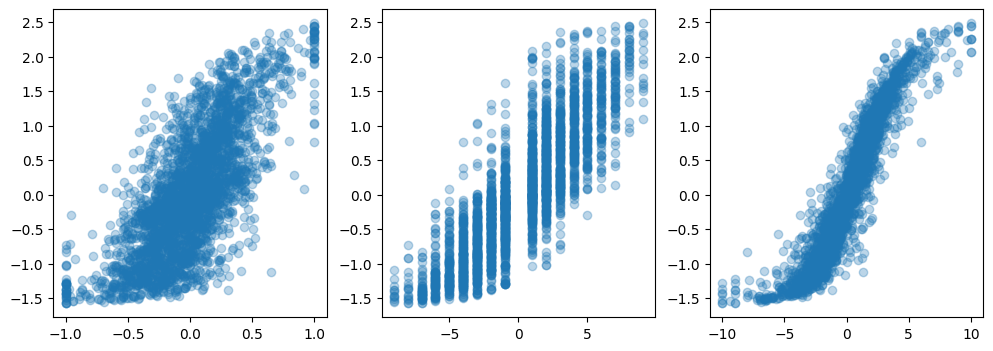

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 1], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 1]*X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

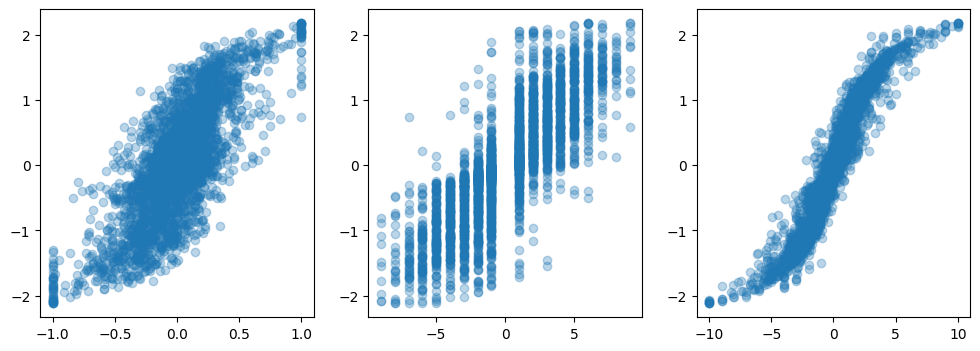

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 0], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 0]*X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);


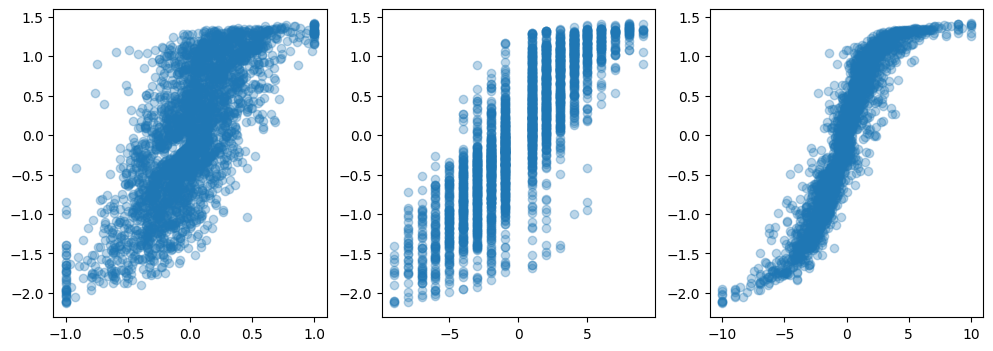

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 4] - X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 1] - X_test[:, 0], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 4] - X_test[:, 0]*X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);
